# Get feature importance / SHAP values

In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as pl
import ml_help
from time import time
import seaborn as sns
sns.set_theme()

/home/uncle_opal/miniconda3/envs/rapids/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/uncle_opal/miniconda3/envs/rapids/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def d

In [2]:
df = pd.read_csv("./data/gardiner_count_weather_incidents.csv.zip")
df

,volume_15min,Num. Lanes,Dist. From Mid. Point,Mag. of Delay,Length,Delay,Visibility,Temperature,Feels Like,Humidity,...,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,160.0,3.0,4.887837,0.0,0.0,0.0,10.0,22.65,22.72,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,170.0,3.0,0.474912,0.0,0.0,0.0,10.0,22.65,22.72,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,169.0,3.0,-0.635254,0.0,0.0,0.0,10.0,22.65,22.72,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,123.0,3.0,-0.633557,0.0,0.0,0.0,10.0,22.65,22.72,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,134.0,3.0,-7.665465,0.0,0.0,0.0,10.0,22.65,22.72,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145236,98.0,3.0,-7.668009,0.0,0.0,0.0,10.0,3.26,1.09,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
145237,439.0,3.0,0.474912,0.0,0.0,0.0,10.0,3.26,1.09,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
145238,243.0,3.0,0.474912,0.0,0.0,0.0,10.0,3.26,1.09,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
145239,365.0,5.0,-1.750579,0.0,0.0,0.0,10.0,3.26,1.09,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [3]:
X = df.drop("volume_15min",axis=1)
y = df["volume_15min"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.80 = 0.20

# XGBoost

Fitting...
Fitting... OK! Took 26.919856548309326 seconds
Explaining...
Explaining... OK! Took 6.862634181976318 seconds
Calculating shap values...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Calculating shap values... OK! Took 144.02498984336853 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


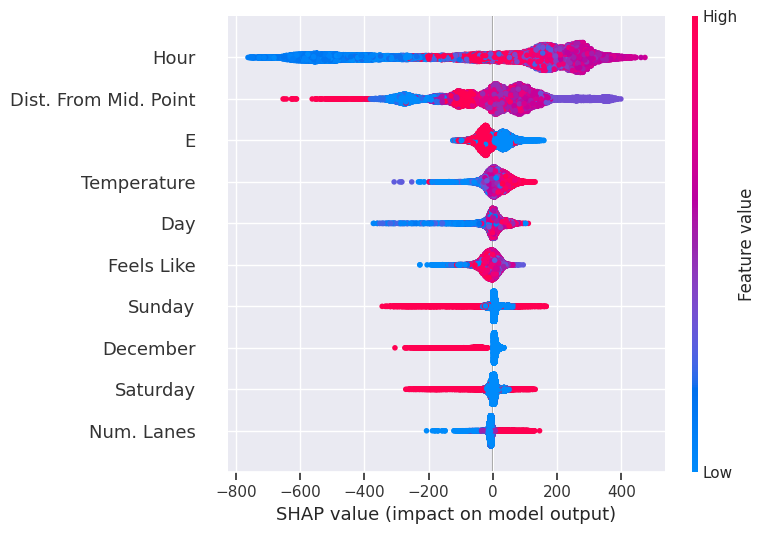

In [5]:
import xgboost as xgb

params = ml_help.params_to_dict("133_xgboost")
params["predictor"] = "cpu_predictor"
params["tree_method"] = "hist"

model = xgb.XGBRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test, check_additivity=False)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
xgboost_fig = pl.gcf()
pl.savefig("./plots/136_xgboost.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/136_xgboost.png", bbox_inches="tight")
pl.savefig("./plots/136_xgboost.pdf", bbox_inches="tight")

# Random Forest

Fitting...
Fitting... OK! Took 29.456355094909668 seconds
Explaining...
Explaining... OK! Took 0.010710477828979492 seconds
Calculating shap values...
Calculating shap values... OK! Took 26.91874098777771 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


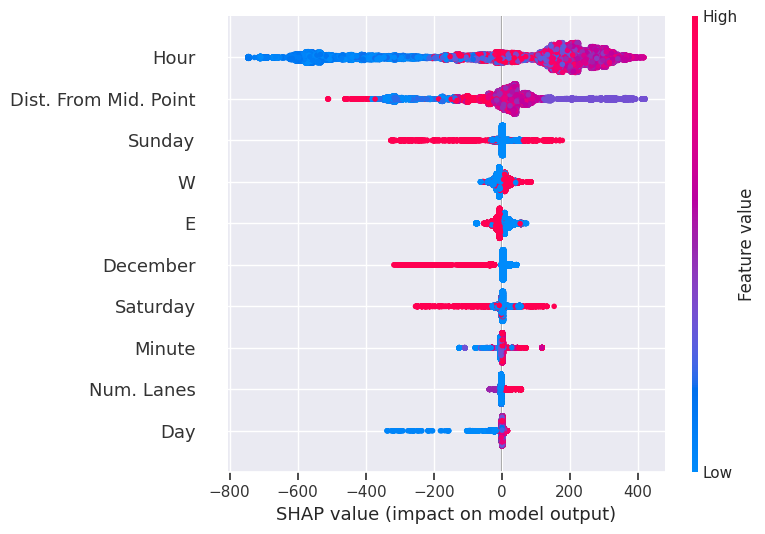

In [6]:
from sklearn.ensemble import RandomForestRegressor

params = ml_help.params_to_dict("133_random_forest")
model = RandomForestRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/136_random_forest.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/136_random_forest.png", bbox_inches="tight")
pl.savefig("./plots/136_random_forest.pdf", bbox_inches="tight")

# Decision Tree

Fitting...
Fitting... OK! Took 0.423429012298584 seconds
Explaining...
Explaining... OK! Took 0.0008037090301513672 seconds
Calculating shap values...
Calculating shap values... OK! Took 0.29551029205322266 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


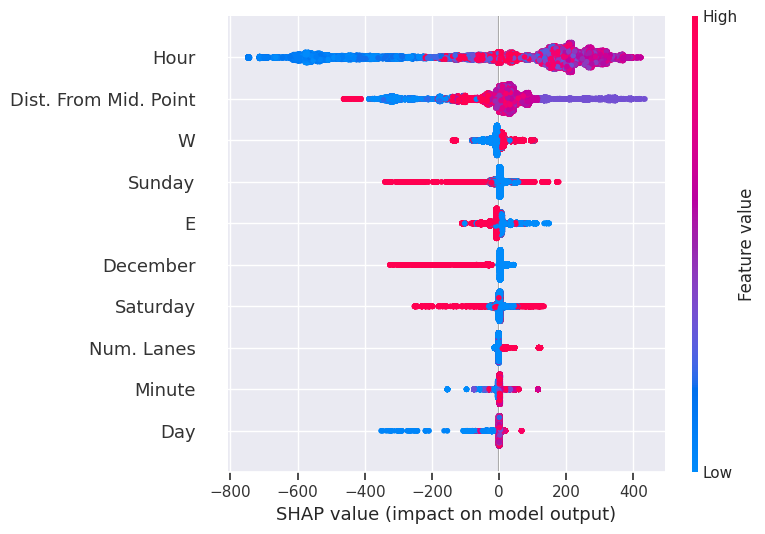

In [7]:
from sklearn.tree import DecisionTreeRegressor

params = ml_help.params_to_dict("133_decision_tree")
model = DecisionTreeRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/136_decision_tree.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/136_decision_tree.png", bbox_inches="tight")
pl.savefig("./plots/136_decision_tree.pdf", bbox_inches="tight")

# MLP

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Fitting...


X does not have valid feature names, but MLPRegressor was fitted with feature names


Fitting... OK! Took 394.60108399391174 seconds
Explaining...
Explaining... OK! Took 0.0007445812225341797 seconds
Calculating shap values...


100%|███████████████████████████████████| 29049/29049 [2:21:33<00:00,  3.42it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Calculating shap values... OK! Took 8493.920215845108 seconds


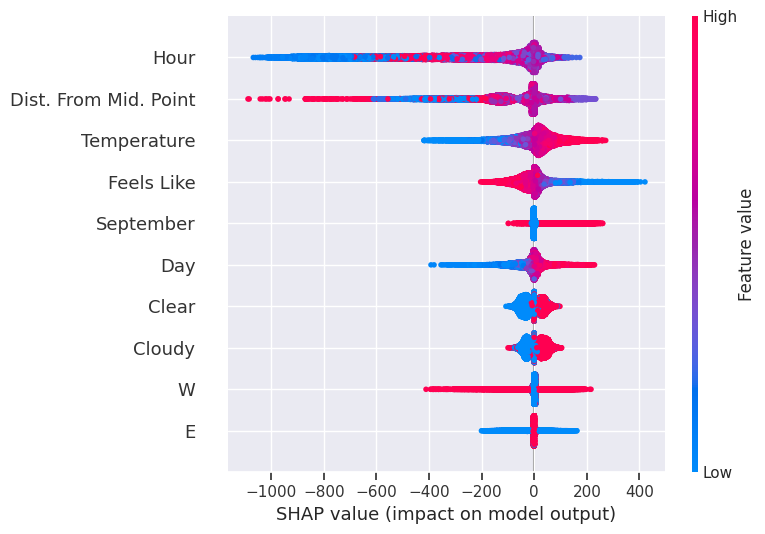

In [8]:
from sklearn.neural_network import MLPRegressor
import warnings

X_train_summary = shap.kmeans(X_train, 10)

params = ml_help.params_to_dict("133_mlpr")
model = MLPRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.KernelExplainer(model.predict, X_train_summary)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/136_mlp.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/136_mlp.png", bbox_inches="tight")
pl.savefig("./plots/136_mlp.pdf", bbox_inches="tight")